# Autoencoders

An autoencoder is always composed of two parts:

- an encoder or recognition network
- a decoder or generative network

The encoder converts the input into a simpler, internal representation, and the decoder is responsible for producing the output from the the internal representation.

Use cases for encoders:
1. Dimensionality reduction
2. Generating new data that looks similar to the original source, such as:
  - Images that vary from original
  - Recommender systems

### How does this work?

More technically:  The hidden layer must have less neurons in order to force the network to learn the most important features in the data. That way, it cannot trivially copy the input to the output. Since the hidden layer has a lower dimensionality than the output, the autoencoder is said to be undercomplete. An undercomplete autoencoder is the simplest type and we will show this in code below. After the lower representaion of neurons... We then increase the number of neurons which become our new representation of data.

Note that this middle layer is imperative in our architecture. If we don't have the middle layer as a bottle neck, and we don't have a non-linear activation function, we have something akin to PCA. Geoffrey Hinton discusses this [here](https://www.youtube.com/watch?v=PSOt7u8u23w). And there's some great visualizations [here](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/unsupervised_learning.html).

#### Cool. Let's code

In [2]:
import numpy as np
import tensorflow as tf

#### Make some random data

In [3]:
np.random.seed(42)

# m by n matrix 
m = 200

w1, w2, = 0.1, 0.3

noise = 0.1

angles = np.random.randn(m) * 3 * np.pi / 2 - 0.5

data = np.empty((m, 3))

In [4]:
data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2

In [5]:
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2

In [6]:
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise + np.random.randn(m)

In [60]:
data[:5]

array([[ 0.23313776,  0.5949343 ,  1.05878268],
       [-0.02159238, -0.66934742, -1.02512879],
       [-0.4991592 ,  0.38938464,  1.03650539],
       [ 1.16800758,  0.27101928,  1.6537444 ],
       [-0.60123706, -0.72213076,  0.23667197]])

Let's scale the data

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()

In [10]:
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

Let's visualize

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

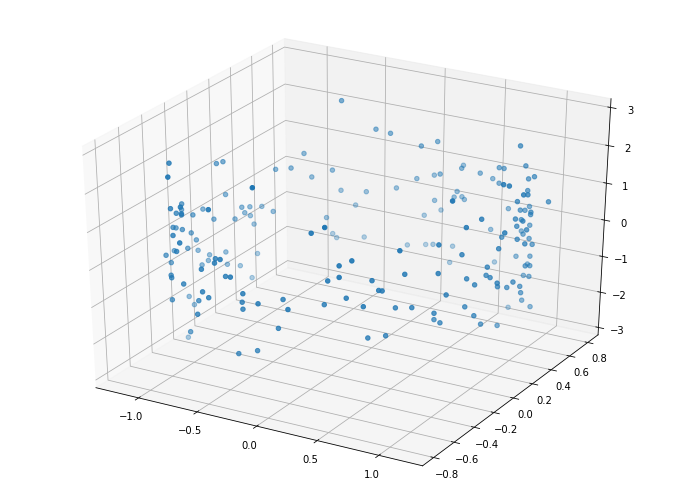

In [12]:
fig = plt.figure(figsize=[12,9])

ax = fig.gca(projection='3d')

ax.scatter3D(data[:, 0], data[:,1], data[:, 2]);

Now let's do some tensorflow.

Specifically, we want to reduce this dataset of 3 dimensions down to 2

In [13]:
n_inputs = 3
n_hidden = 2
n_outputs = 3

In [14]:
learning_rate = 0.01

In [15]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [16]:
hidden = tf.layers.dense(X, n_hidden)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
outputs = tf.layers.dense(hidden, n_outputs)

In [18]:
loss = tf.reduce_mean(tf.square(outputs - X))

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate)

In [20]:
training_op = optimizer.minimize(loss)

In [21]:
init = tf.global_variables_initializer()

In [22]:
n_iterations = 1000

In [23]:
codings = hidden

In [24]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
        
    codings_val = codings.eval(feed_dict={X:X_train})

In [25]:
codings_val[:5]

array([[-1.2737267 ,  0.3895393 ],
       [ 1.4555019 , -0.03542943],
       [-1.0999918 , -0.517019  ],
       [-1.8723153 ,  0.2825516 ],
       [ 0.18932484, -1.5727887 ]], dtype=float32)

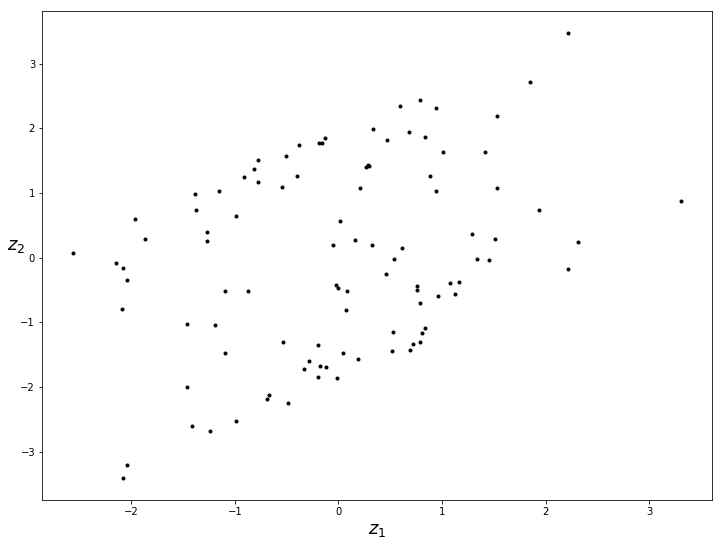

In [26]:
fig = plt.figure(figsize=[12,9])

plt.plot(codings_val[:,0], codings_val[:,1], 'k.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.show()

### MNIST

Let's try stacking multiple layers to reduce dimensionality on the mnist dataset

In our manufactured dataset, we used 2 hidden layers. Let's go deeper and apply this to a toy dataset - MNIST. 

In [27]:
from tensorflow.examples.tutorials.mnist import input_data

In [28]:
mnist = input_data.read_data_sets('/tmp/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [29]:
from functools import partial

Mnist is 28 by 28 pixels, so we'll initialize with that as our inputs

In [30]:
n_inputs = 28 * 28

First hidden layer

In [31]:
n_hidden1 = 300

Second hidden layer

In [32]:
n_hidden2 = 150

Then our third layer is equivalent to the first. Our architecture looks like:
<img src = 'https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png' width=400 height=400>

In [33]:
n_hidden3 = n_hidden1

In [34]:
n_outputs = n_inputs

In [35]:
l2_reg = 0.0001

In [36]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [37]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [38]:
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [39]:
my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

In [40]:
hidden1 = my_dense_layer(X, n_hidden1)

In [41]:
hidden2 = my_dense_layer(hidden1, n_hidden2)

In [42]:
hidden3 = my_dense_layer(hidden2, n_hidden3)

In [43]:
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

In [44]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [45]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

In [46]:
loss = tf.add_n([reconstruction_loss] + reg_losses)

In [47]:
optimizer = tf.train.AdamOptimizer(learning_rate)

In [48]:
training_op = optimizer.minimize(loss)

In [49]:
init = tf.global_variables_initializer()

In [50]:
saver = tf.train.Saver()

Train that bia

In [51]:
n_epochs = 10
batch_size = 150

In [52]:
import sys

In [53]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad) * n_cols + pad))
    
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y * (h + pad) + pad):(y * (h + pad) + pad + h),(x * (w + pad) + pad):(x * (w + pad) + pad + w)] = images[y * n_cols + x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [54]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X:X_batch})
        
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")
    

0 Train MSE: 0.025428787
1 Train MSE: 0.0130698895
2 Train MSE: 0.010769633
3 Train MSE: 0.010593606
4 Train MSE: 0.0108730085
5 Train MSE: 0.011257206
6 Train MSE: 0.010888043
7 Train MSE: 0.010754315
8 Train MSE: 0.011656901
9 Train MSE: 0.012217031


In [55]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits =3):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
        
    fig = plt.figure(figsize=(8,3 *n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


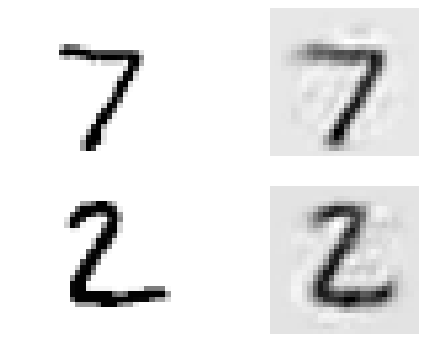

In [58]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt", n_test_digits=2)

## Variational Autoencoders

A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space. Thus, rather than building an encoder which outputs a single value to describe each latent state attribute, we'll formulate our encoder to describe a probability distribution for each latent attribute.

Intuitively, you can think of VAEs like this:

<img src = 'https://cdn-images-1.medium.com/max/2000/1*96ho7qSyW0nKrLvSoZHOtA.png' height=400 width=400>

The mean vector controls where the encoding of an input should be centered around, while the standard deviation controls the “area”, how much from the mean the encoding can vary. As encodings are generated at random from anywhere inside the “circle” (the distribution), the decoder learns that not only is a single point in latent space referring to a sample of that class, but all nearby points refer to the same as well.

In [61]:
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10    # To avoid computing log(0)

latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [62]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 31966.633 	Reconstruction loss: 25041.107 	Latent loss: 6925.5244
1 Train total loss: 26331.355 	Reconstruction loss: 21942.568 	Latent loss: 4388.788
2 Train total loss: 25441.273 	Reconstruction loss: 21340.09 	Latent loss: 4101.1826
3 Train total loss: 32915.164 	Reconstruction loss: 25422.781 	Latent loss: 7492.385
4 Train total loss: 29460.441 	Reconstruction loss: 24495.602 	Latent loss: 4964.8403
5 Train total loss: 25884.32 	Reconstruction loss: 20611.988 	Latent loss: 5272.3315
6 Train total loss: 27649.836 	Reconstruction loss: 23003.646 	Latent loss: 4646.1885
7 Train total loss: 19938.15 	Reconstruction loss: 17149.14 	Latent loss: 2789.0105
8 Train total loss: 18775.422 	Reconstruction loss: 15883.789 	Latent loss: 2891.632
9 Train total loss: 17750.402 	Reconstruction loss: 14767.037 	Latent loss: 2983.365
10 Train total loss: 17306.113 	Reconstruction loss: 14048.863 	Latent loss: 3257.2505
11 Train total loss: 17544.102 	Reconstruction loss: 14541.33

### Plotting the digits

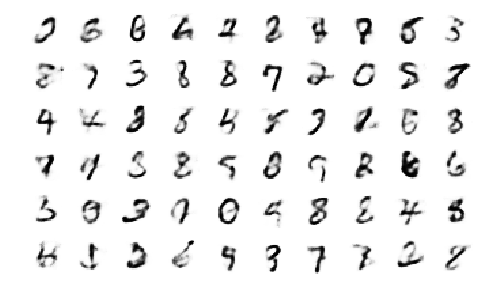

In [64]:
plt.figure(figsize=(8,50)) 
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

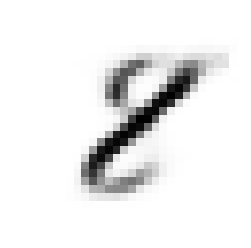

In [68]:
plot_image(outputs_val[iteration])

# Citations:

- http://www.deeplearningbook.org/contents/generative_models.html
- https://www.youtube.com/watch?v=9zKuYvjFFS8
- https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf 
- Time killer: visual representation of VAEs. https://www.siarez.com/projects/variational-autoencoder

If any of the pieces of the net composed above didn't make sense... some resources:
- Adam: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
- ELU: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html